# Evaluation
What is the final result?

In [1]:
import keras
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import kapre
from utils import DataFeed
import sys

%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
sys.path.append('../preprocessing')

Using TensorFlow backend.


## Load Data

In [2]:
data_path = '../preprocessing/preprocessed_data'
data_vox, labels_vox = DataFeed.Dataset.create(data_path, ['test/voxforge'], num=-1, shuffle=True)
data_vox.shape

(5000, 1, 80000)

In [3]:
data_you, labels_you = DataFeed.Dataset.create(data_path, ['test/youtube'], num=-1, shuffle=True)
data_you.shape

(5000, 1, 80000)

In [4]:
data_lib, labels_lib = DataFeed.Dataset.create(data_path, ['test/librivox_big', 'test/librivox'], num=-1, shuffle=True)
data_lib.shape

(6120, 1, 80000)

In [5]:
data_voxyou, labels_voxyou = DataFeed.Dataset.create(data_path, ['test/youtube', 'test/voxforge'], num=-1, shuffle=True)
data_voxyou.shape

(10000, 1, 80000)

In [7]:
import IPython.display as ipd
ipd.Audio(data_lib[30], rate=16000)

## Evaluate Metrics

In [8]:
models = ['conv2d_to_rnn/conv2d_to_rnn.h5', 'berlin_net/berlin_net.h5', 'conv2d_deep/conv2d_deep.h5', 'model_ens.h5']

In [11]:
def evaluate(models, data, labels):
    for mpath in models:
        model = load_model(mpath, custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                  'Normalization2D': kapre.utils.Normalization2D})
        model.compile(optimizer='RMSprop',
              metrics=['accuracy', 'mae'],
              loss='categorical_crossentropy')
        
        metrics = model.evaluate(x=data, y=labels, verbose=0)
        metrics_names = model.metrics_names
        print(mpath + ":")
        for i in range(len(metrics)):
            print("    " + metrics_names[i] + ": " + str(metrics[i]))

In [12]:
evaluate(models, data_vox, labels_vox)

int_axis=0 passed but is ignored, str_axis is used instead.
conv2d_to_rnn/conv2d_to_rnn.h5:
    loss: 0.14626698986887932
    acc: 0.9694
    mean_absolute_error: 0.02631037959828973
int_axis=0 passed but is ignored, str_axis is used instead.
berlin_net/berlin_net.h5:
    loss: 0.1279899318918586
    acc: 0.9554
    mean_absolute_error: 0.040671488276124
conv2d_deep/conv2d_deep.h5:
    loss: 0.49330678886175156
    acc: 0.861
    mean_absolute_error: 0.10484074419140815
int_axis=0 passed but is ignored, str_axis is used instead.
int_axis=0 passed but is ignored, str_axis is used instead.
model_ens.h5:
    loss: 0.17342952914237977
    acc: 0.9786
    mean_absolute_error: 0.05727419859170914


In [13]:
evaluate(models, data_you, labels_you)

int_axis=0 passed but is ignored, str_axis is used instead.
conv2d_to_rnn/conv2d_to_rnn.h5:
    loss: 0.21479699566364288
    acc: 0.9474
    mean_absolute_error: 0.040265166784077884
int_axis=0 passed but is ignored, str_axis is used instead.
berlin_net/berlin_net.h5:
    loss: 0.1549366238296032
    acc: 0.9466
    mean_absolute_error: 0.05226245715618134
conv2d_deep/conv2d_deep.h5:
    loss: 0.778121430683136
    acc: 0.8018
    mean_absolute_error: 0.14081728105545044
int_axis=0 passed but is ignored, str_axis is used instead.
int_axis=0 passed but is ignored, str_axis is used instead.
model_ens.h5:
    loss: 0.22468616335391997
    acc: 0.9548
    mean_absolute_error: 0.07778162899017334


In [14]:
evaluate(models, data_lib, labels_lib)

int_axis=0 passed but is ignored, str_axis is used instead.
conv2d_to_rnn/conv2d_to_rnn.h5:
    loss: 0.23760612719978383
    acc: 0.9406862745098039
    mean_absolute_error: 0.04782653888261396
int_axis=0 passed but is ignored, str_axis is used instead.
berlin_net/berlin_net.h5:
    loss: 0.3402759737438626
    acc: 0.8810457516339869
    mean_absolute_error: 0.09411102655081967
conv2d_deep/conv2d_deep.h5:
    loss: 1.9547722598306494
    acc: 0.5676470588235294
    mean_absolute_error: 0.29156331688750026
int_axis=0 passed but is ignored, str_axis is used instead.
int_axis=0 passed but is ignored, str_axis is used instead.
model_ens.h5:
    loss: 0.37526385262121564
    acc: 0.9225490196078432
    mean_absolute_error: 0.14450028910745982


## Confusion Matrix

In [21]:
# Make Predictions and reformat
best_model = load_model(models[0], custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                  'Normalization2D': kapre.utils.Normalization2D})
preds = best_model.predict(x=data_voxyou)
preds = np.argmax(preds, axis=1) # [[0, 1, 0], [1, 0, 0]] -> [1, 0]
labels = np.argmax(labels_voxyou, axis=1)

int_axis=0 passed but is ignored, str_axis is used instead.


In [22]:
# calculate matrix
c = confusion_matrix(labels, preds)
c

array([[3236,   65,   33],
       [  40, 3171,  121],
       [  34,  122, 3178]])

In [23]:
def plot_confusion_matrix(matrix,
                          normalize=False,
                          title='Wahrheitsmatrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum()

    plt.rcParams.update({'font.size': 30})
    plt.figure(figsize=(10, 10))
    
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    if title: 
        plt.title(title)
    tick_marks = np.arange(3)
    classes= ['FR', 'EN', 'DE']
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar(fraction=0.046, pad=0.04)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('Wahre Antwort')
    plt.xlabel('Berechnete Antwort')
    plt.tight_layout()

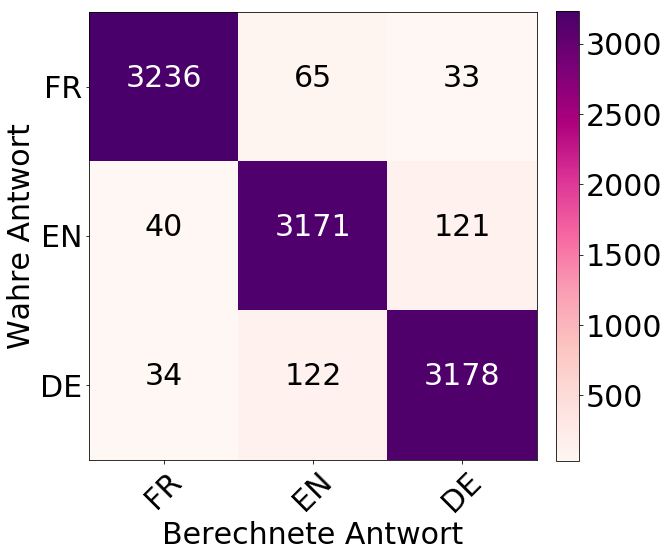

In [24]:
plot_confusion_matrix(c, normalize=False, title=False, cmap=plt.cm.RdPu)

int_axis=0 passed but is ignored, str_axis is used instead.


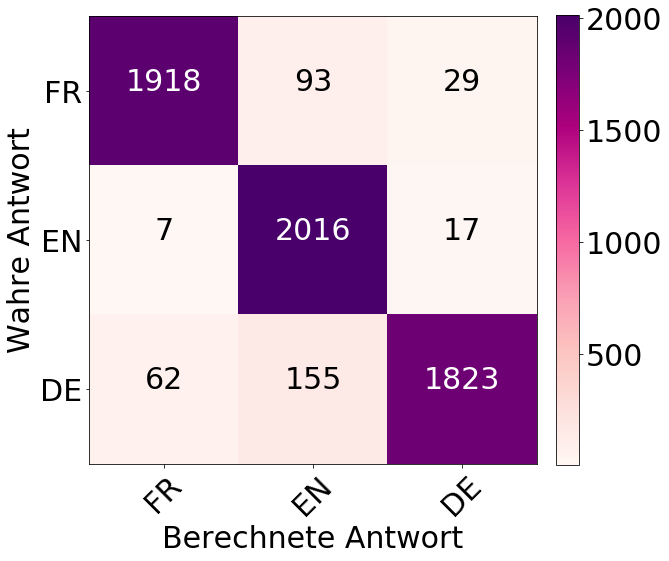

In [28]:
# Make Predictions and reformat
best_model = load_model(models[0], custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                  'Normalization2D': kapre.utils.Normalization2D})
preds = best_model.predict(x=data_lib)
preds = np.argmax(preds, axis=1) # [[0, 1, 0], [1, 0, 0]] -> [1, 0]
labels = np.argmax(labels_lib, axis=1)

# calculate matrix
c = confusion_matrix(labels, preds)
c

plot_confusion_matrix(c, normalize=False, title=False, cmap=plt.cm.RdPu)